# Demo notebook for Computer aided detection with Faster-RCNN

### Prerequisites

* You need to install py-faster-rcnn, see the github repository for instructions: https://github.com/rbgirshick/py-faster-rcnn

* You need a GPU with at least 8GB memory, with CUDA and cuDNN

### Import modules and change Faster-RCNN configs

In [2]:
import sys
# here is my py-faster-rcnn installation
sys.path.append('/opt/py-faster-rcnn/tools/')  
import _init_paths
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
import caffe, cv2
from matplotlib import pyplot as plt
import numpy as np
#import imageio

# faster rcnn configs we need to change
cfg.TEST.HAS_RPN = True  # Use RPN for proposals
cfg.TEST.SCALES=(1737,)  # change scales
cfg.TEST.MAX_SIZE=2145  # change scales

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Define functions to load model, run detection, and visualize detection

In [11]:
def load_net(ptxt, w, device=0):
    """Load model."""
    caffe.set_mode_gpu()
    caffe.set_device(device)
    cfg.GPU_ID = device
    net = caffe.Net(ptxt, w, caffe.TEST)
    return net


def detect(net, im,  NMS_THRESH = 0.1, cls_ind = 2,
           CLASSES = ('__background__','BENIGN','MALIGNANT')):
    """Detect cancer."""
    cfg.TEST.HAS_RPN = True
    scores, boxes =  im_detect(net, im)
    
    cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
    cls_scores = scores[:, cls_ind]
    dets = np.hstack((cls_boxes,
                        cls_scores[:, np.newaxis])).astype(np.float32)
    keep = nms(dets, NMS_THRESH)
    dets = dets[keep, :]
    return dets


def vis_detections(im, dets, CONF_THRESH = 0.23, compressed=False):
    CONF_THRESH = 0.1
    """Draw boxes around detected cancer."""   
    fig,ax = plt.subplots(figsize=(8,10))
    ax.imshow(im,cmap='gray_r')
    inds = np.where(dets[:, -1] >= CONF_THRESH)[0]
    scores_only = [0]
    
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]
        
        #if not compressed:
            #print("Lesion {}".format(i+1))
            #print("Confidence of class as malignant: {}".format(score))
            #print("Locations: Top left coordinate: {}, {} \n".format(bbox[0], bbox[1]))
        #else:
            #print("Lesion {0}, Malignant {1}".format(i+1, score))
        
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False, linestyle ='dashed',
                          edgecolor=(0.95, 0.95, 0.5), linewidth=3))
        plt.text(bbox[0], bbox[1], "ROI "+str(i+1)+": "+"\n"+"{:.2f}".format(score), fontsize=12, color="red")
        scores_only.append(score)
    
    #plt.axis('off')
    #plt.tight_layout()
    #plt.axis('off') #Turning axis on/off
    plt.tight_layout()
    #plt.show()
    return fig, ax, scores_only
    

### Load the model

In [9]:
# place the model weights here
net = load_net(ptxt='vgg16_frcnn_cad_test.prototxt',
               w='vgg16_frcnn_cad.caffemodel')

### Load and analyze image



######
Spiculated Density 1.56
######



######
Lobular Density 1.56
######



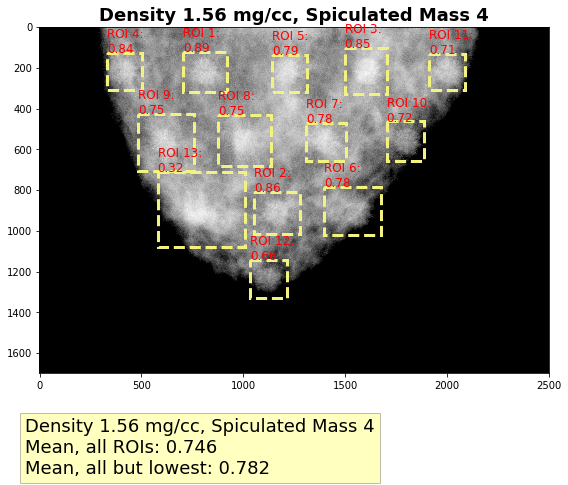

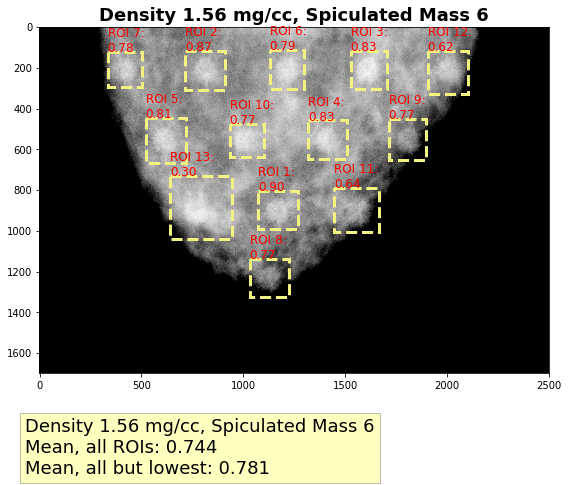

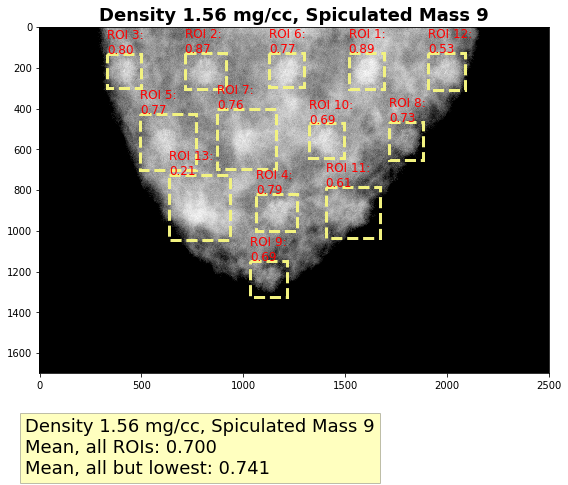

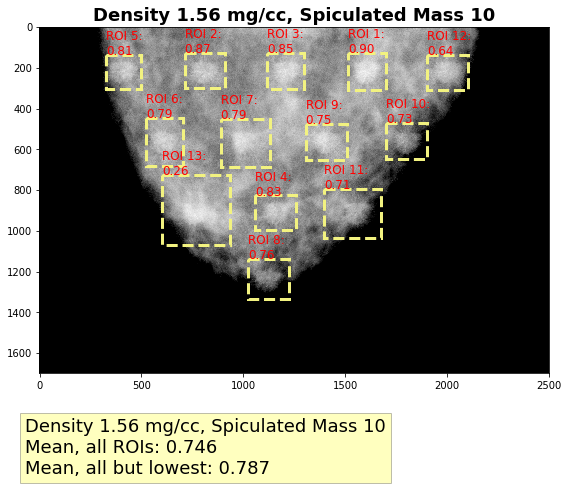

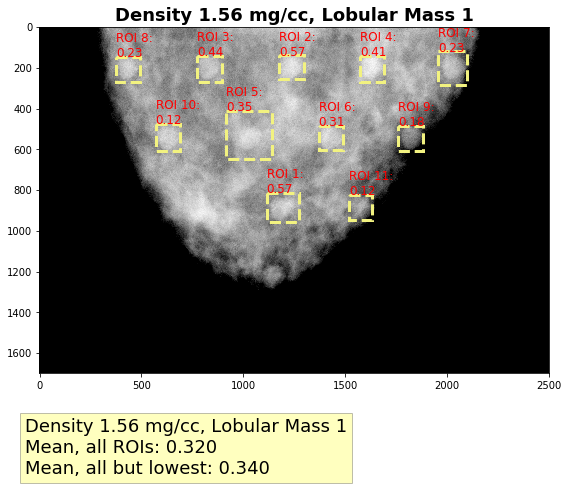

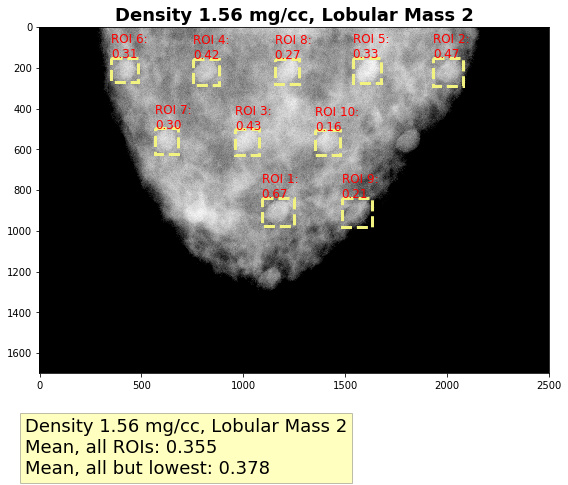

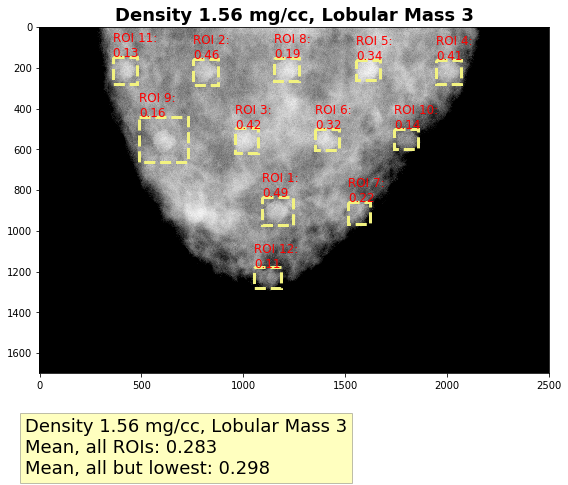

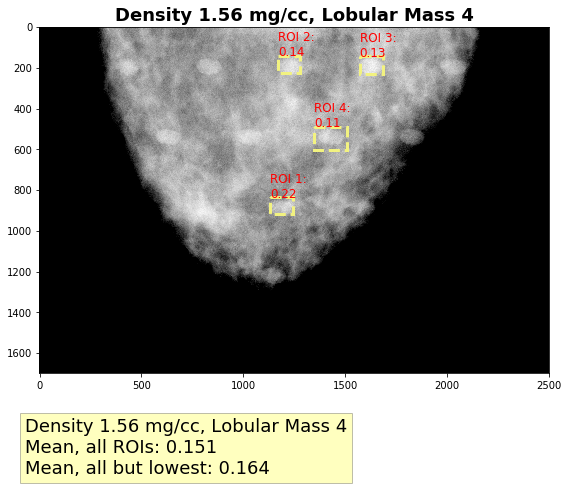

In [44]:
# load image, customize this part to load your images 
# from whatever format you use
#text(0.5, 0.5, 'matplotlib1', fontsize=14, bbox=dict(facecolor='red', alpha=0.5), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
spiculatedInds = [4, 6, 9, 10]
lobularInds = [1, 2, 3, 4]
fpath = '/opt/images/postproc_mass/texture/'

density = '1.56'
print('\n\n######')
print('Spiculated Density '+density)
print('######\n')
for ind in spiculatedInds:
    fname = "SameSpicMaligTestMass"+str(ind)+"_1740x2415x1140_array0_density"+density+"_full_1.0_15_8bit.png"
    im = cv2.imread(fpath+fname)
    detections = detect(net, im)
    fig, ax, scores_only = vis_detections(im, detections)
    ax.set_title("Density "+density+" mg/cc, Spiculated Mass "+str(ind), fontsize=18, fontweight='bold')
    footnote = "Density "+density+" mg/cc, Spiculated Mass {}\nMean, all ROIs: {:.3f} \nMean, all but lowest: {:.3f}".format(ind, np.mean(scores_only[1:]), np.mean(scores_only[1:-1]))
    plt.figtext(0.05, 0.12, footnote, ha="left", fontsize=18, bbox={"facecolor":"yellow", "alpha":0.25, "pad":5})
    fig
    cadFname = fpath+"CAD_SameSpicMaligTestMass"+str(ind)+"_density"+density+"_1.7e11_full_1.0_15.png"
    #print(cadFname)
    plt.savefig(cadFname)
    

density = '1.56'
print('\n\n######')
print('Lobular Density '+density)
print('######\n')
for ind in lobularInds:
    fname = "SameLobMaligTestMass"+str(ind)+"_1740x2415x1140_array0_density"+density+"_full_1.0_15_8bit.png"
    im = cv2.imread(fpath+fname)
    detections = detect(net, im)
    fig, ax, scores_only = vis_detections(im, detections)
    ax.set_title("Density "+density+" mg/cc, Lobular Mass "+str(ind), fontsize=18, fontweight='bold')
    footnote = "Density "+density+" mg/cc, Lobular Mass {}\nMean, all ROIs: {:.3f} \nMean, all but lowest: {:.3f}".format(ind, np.mean(scores_only[1:]), np.mean(scores_only[1:-1]))
    plt.figtext(0.05, 0.12, footnote, ha="left", fontsize=18, bbox={"facecolor":"yellow", "alpha":0.25, "pad":5})
    fig
    cadFname = fpath+"CAD_SameLobMaligTestMass"+str(ind)+"_density"+density+"_1.7e11_full_1.0_15.png"
    #print(cadFname)
    plt.savefig(cadFname)
    
# density = '1.56'
# print('\n\n######')
# print('Spiculated Density '+density)
# print('######\n')
# for ind in spiculatedInds:
#     fname = "SameSpicMaligTestMass"+str(ind)+"_1740x2415x1140_array0_density"+density+"_full_1.0_15_8bit.png"
#     im = cv2.imread(fpath+fname)
#     detections = detect(net, im)
#     fig, ax, scores_only = vis_detections(im, detections)
#     ax.set_title("Density "+density+" mg/cc, Spiculated Mass "+str(ind), fontsize=18, fontweight='bold')
#     footnote = "Density "+density+" mg/cc, Spiculated Mass {}\nMean, all ROIs: {:.3f} \nMean, all but lowest: {:.3f}".format(ind, np.mean(scores_only[1:]), np.mean(scores_only[1:-1]))
#     plt.figtext(0.05, 0.12, footnote, ha="left", fontsize=18, bbox={"facecolor":"yellow", "alpha":0.25, "pad":5})
#     fig
#     cadFname = fpath+"CAD_SameSpicMaligTestMass"+str(ind)+"_density"+density+"_1.7e11_full_1.0_15.png"
#     #print(cadFname)
#     plt.savefig(cadFname)


		################################################



######
Spiculated Density 1.06
######



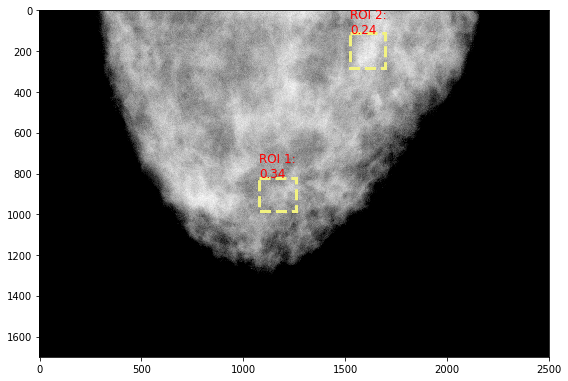

Density 1.06 mg/cc
Spiculated Mass 4
Mean, all ROIs: 0.287742823362
Mean, all but lowest: 0.336680173874



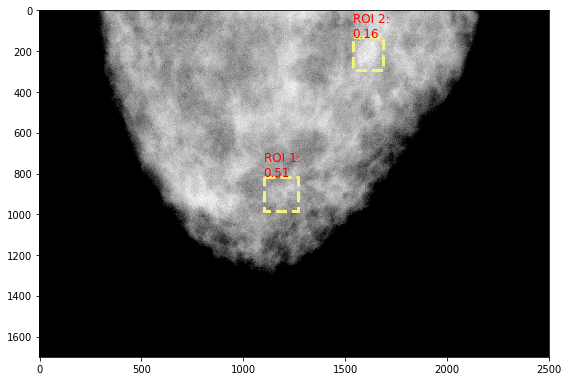

Density 1.06 mg/cc
Spiculated Mass 6
Mean, all ROIs: 0.338149428368
Mean, all but lowest: 0.513049304485



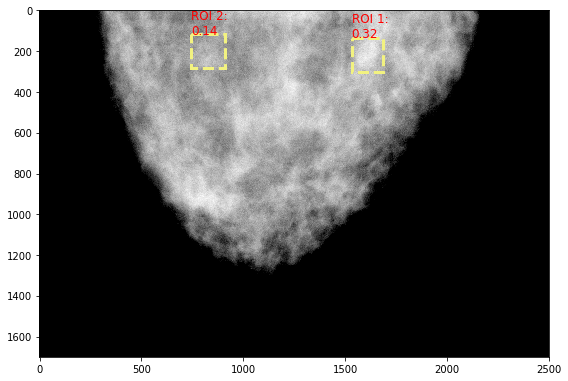

Density 1.06 mg/cc
Spiculated Mass 9
Mean, all ROIs: 0.228108391166
Mean, all but lowest: 0.315299898386



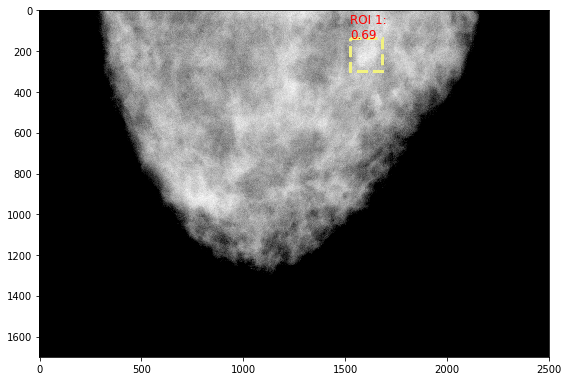

Density 1.06 mg/cc
Spiculated Mass 10
Mean, all ROIs: 0.69029712677
Mean, all but lowest: nan



######
Lobular Density 1.06
######



/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


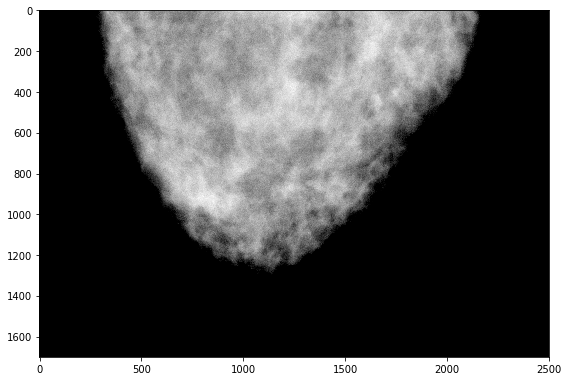

Density 1.06 mg/cc
Lobular Mass 1
Mean, all ROIs: nan
Mean, all but lowest: nan



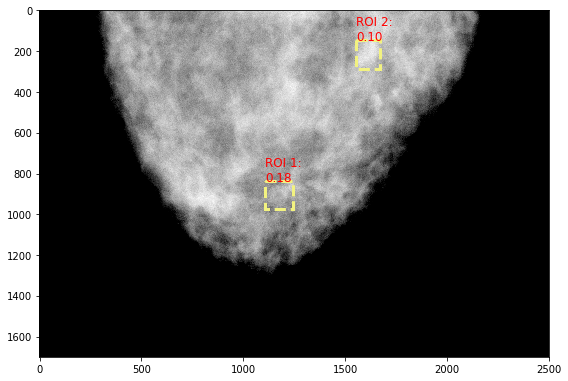

Density 1.06 mg/cc
Lobular Mass 2
Mean, all ROIs: 0.13964240253
Mean, all but lowest: 0.178423911333



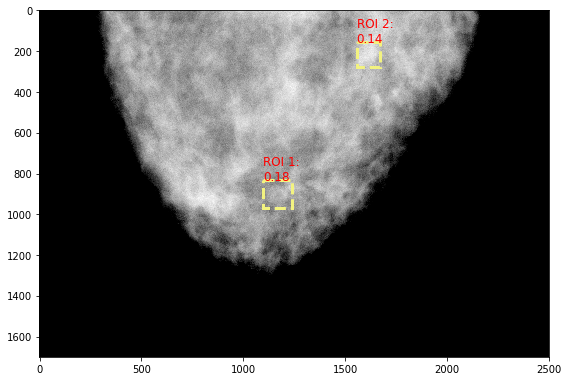

Density 1.06 mg/cc
Lobular Mass 3
Mean, all ROIs: 0.158639416099
Mean, all but lowest: 0.180313199759



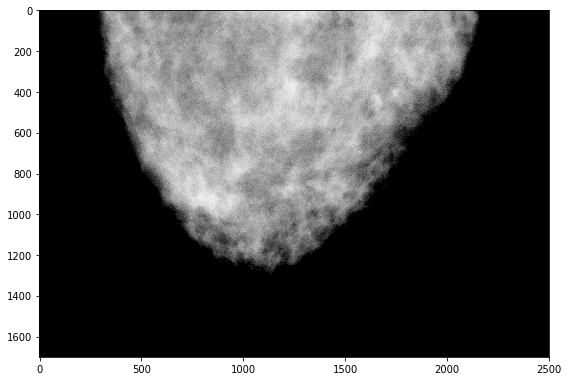

Density 1.06 mg/cc
Lobular Mass 4
Mean, all ROIs: nan
Mean, all but lowest: nan



In [6]:
spiculatedInds = [4, 6, 9, 10]
lobularInds = [1, 2, 3, 4]
fpath = '/opt/images/postproc_mass/texture/'

# density = '1.26'
# print('\n\n######')
# print('Spiculated Density '+density)
# print('######\n')
# for ind in spiculatedInds:
#     fname = "SameSpicMaligTestMass"+str(ind)+"_1740x2415x1140_array0_density"+density+"_full_1.0_15_8bit.png"
#     im = cv2.imread(fpath+fname)
#     detections = detect(net, im)
#     fig, scores_only = vis_detections(im, detections)
#     print("Density "+density+" mg/cc")
#     print("Spiculated Mass {}".format(ind))
#     print("Mean, all ROIs: {}".format(np.mean(scores_only[1:])))
#     print("Mean, all but lowest: {}\n".format(np.mean(scores_only[1:-1])))

# print('\n\n######')
# print('Lobular Density '+density)
# print('######\n')
# for ind in lobularInds:
#     fname = "SameLobMaligTestMass"+str(ind)+"_1740x2415x1140_array0_density"+density+"_full_1.0_15_8bit.png"
#     im = cv2.imread(fpath+fname)
#     detections = detect(net, im)
#     fig, scores_only = vis_detections(im, detections)
#     print("Density "+density+" mg/cc")
#     print("Lobular Mass {}".format(ind))
#     print("Mean, all ROIs: {}".format(np.mean(scores_only[1:])))
#     print("Mean, all but lowest: {}\n".format(np.mean(scores_only[1:-1])))

#
####
print('\n\t\t################################################\n')
####
#
density = '1.06'
print('\n\n######')
print('Spiculated Density '+density)
print('######\n')
for ind in spiculatedInds:
    fname = "SameSpicMaligTestMass"+str(ind)+"_1740x2415x1140_array0_density"+density+"_full_1.0_15_8bit.png"
    im = cv2.imread(fpath+fname)
    detections = detect(net, im)
    fig, scores_only = vis_detections(im, detections)
    print("Density "+density+" mg/cc")
    print("Spiculated Mass {}".format(ind))
    print("Mean, all ROIs: {}".format(np.mean(scores_only[1:])))
    print("Mean, all but lowest: {}\n".format(np.mean(scores_only[1:-1])))

print('\n\n######')
print('Lobular Density '+density)
print('######\n')
for ind in lobularInds:
    fname = "SameLobMaligTestMass"+str(ind)+"_1740x2415x1140_array0_density"+density+"_full_1.0_15_8bit.png"
    im = cv2.imread(fpath+fname)
    detections = detect(net, im)
    fig, scores_only = vis_detections(im, detections)
    print("Density "+density+" mg/cc")
    print("Lobular Mass {}".format(ind))
    print("Mean, all ROIs: {}".format(np.mean(scores_only[1:])))
    print("Mean, all but lowest: {}\n".format(np.mean(scores_only[1:-1])))


#im = cv2.imread('/opt/images/postproc_mass/texture/SameLobMaligTest_1740x2415x1140_array0_density1.06_full_1.0_15_8bit.png')
#detections = detect(net, im)
#fig, scores_only = vis_detections(im, detections)
#print('Mass Lobular: ')
#print("Mean, all ROIs: {}".format(np.mean(scores_only[1:])))
#print("Mean, all but lowest: {}".format(np.mean(scores_only[1:-1]))

### That's it

The example image is from the INBreast dataset. Courtesy of the Breast Research Group, INESC Porto, Portugal. Thank you.